<h1>A. Data Collection & Exploration

In [1]:
import numpy as np, matplotlib as mpl, matplotlib.pyplot as plt, pandas as pd
import seaborn as sns
%matplotlib inline
import sklearn
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from mpl_toolkits import mplot3d
from sklearn.preprocessing import LabelEncoder
from pylift import TransformedOutcome
from pylift.generate_data import dgp
from pylift.eval import UpliftEval


In [2]:
df_data = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')
df_data.index.name = "id"
df_model = df_data.copy()

<h1>B. Data Preprocessing

In [3]:
#Checking uniques data in Department column
object_cols = [col for col in df_data.columns if df_data[col].dtype == "object"]
for col in object_cols:
    uniques = df_data[col].unique()
    print('\nB.3. All unique data in {} column:\n>>{}'.format(col,uniques))


B.3. All unique data in Attrition column:
>>['Yes' 'No']

B.3. All unique data in BusinessTravel column:
>>['Travel_Rarely' 'Travel_Frequently' 'Non-Travel']

B.3. All unique data in Department column:
>>['Sales' 'Research & Development' 'Human Resources']

B.3. All unique data in EducationField column:
>>['Life Sciences' 'Other' 'Medical' 'Marketing' 'Technical Degree'
 'Human Resources']

B.3. All unique data in Gender column:
>>['Female' 'Male']

B.3. All unique data in JobRole column:
>>['Sales Executive' 'Research Scientist' 'Laboratory Technician'
 'Manufacturing Director' 'Healthcare Representative' 'Manager'
 'Sales Representative' 'Research Director' 'Human Resources']

B.3. All unique data in MaritalStatus column:
>>['Single' 'Married' 'Divorced']

B.3. All unique data in Over18 column:
>>['Y']

B.3. All unique data in OverTime column:
>>['Yes' 'No']


In [4]:
#put data manually with hierarchy into label_cols
label_cols=['BusinessTravel']
#Label encoding
label_encoder = LabelEncoder()
for col in label_cols:
    df_model[col] = label_encoder.fit_transform(df_data[col])
    df_model[col] = label_encoder.transform(df_data[col])

In [5]:
#convert attrition column to stay column with yes=0 and no=1
df_model = df_model.rename(columns={"Attrition": "Stay"})
df_model.Stay.replace(to_replace = dict(Yes = 0, No = 1), inplace = True)
df_model = df_model.rename(columns={"OverTime": "NotOverTime"})
df_model.NotOverTime.replace(to_replace = dict(Yes = 0, No = 1), inplace = True)

In [6]:
#function to order clusters
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [7]:
from sklearn.cluster import KMeans
#creating the clusters
kmeans = KMeans(n_clusters=5)
kmeans.fit(df_model[['MonthlyRate']])
df_model['MonthlyRate_cluster'] = kmeans.predict(df_model[['MonthlyRate']])
kmeans.fit(df_model[['DailyRate']])
df_model['DailyRate_cluster'] = kmeans.predict(df_model[['DailyRate']])
kmeans.fit(df_model[['MonthlyIncome']])
df_model['MonthlyIncome_cluster'] = kmeans.predict(df_model[['MonthlyIncome']])
kmeans.fit(df_model[['HourlyRate']])
df_model['HourlyRate_cluster'] = kmeans.predict(df_model[['HourlyRate']])
kmeans.fit(df_model[['Age']])
df_model['Age_cluster'] = kmeans.predict(df_model[['Age']])
kmeans.fit(df_model[['DistanceFromHome']])
df_model['DistanceFromHome_cluster'] = kmeans.predict(df_model[['DistanceFromHome']])
#order the clusters
df_model = order_cluster('MonthlyRate_cluster', 'MonthlyRate',df_model,True)
df_model = order_cluster('DailyRate_cluster', 'DailyRate',df_model,True)
df_model = order_cluster('MonthlyIncome_cluster', 'MonthlyIncome',df_model,True)
df_model = order_cluster('HourlyRate_cluster', 'HourlyRate',df_model,True)
df_model = order_cluster('Age_cluster', 'Age',df_model,True)
df_model = order_cluster('DistanceFromHome_cluster', 'DistanceFromHome',df_model,True)
#creating a new dataframe as model and dropping columns that defines the label and other useless columns
df_model = df_model.drop(['DistanceFromHome','EmployeeNumber','EmployeeCount','Over18','StandardHours','MonthlyRate','MonthlyIncome','HourlyRate','DailyRate','Age'],axis=1)
#convert categorical columns ('MaritalStatus','JobRole', 'Gender','EducationField','Department')
df_model = pd.get_dummies(df_model)

In [8]:
df_model

,Stay,BusinessTravel,Education,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobSatisfaction,NumCompaniesWorked,NotOverTime,PercentSalaryHike,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
0,0,2,2,2,3,2,4,8,0,11,...,0,0,0,0,0,1,0,0,0,1
1,0,2,2,1,2,3,3,9,0,13,...,1,0,0,0,0,0,0,0,0,1
2,1,2,1,2,3,2,3,1,1,25,...,0,0,0,0,0,1,0,0,1,0
3,1,0,4,3,3,2,2,7,1,11,...,0,0,0,0,0,1,0,0,1,0
4,1,1,4,1,3,2,4,1,1,20,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,1,2,1,4,3,1,4,3,1,11,...,1,0,0,0,0,0,0,0,1,0
1466,1,2,1,2,3,1,3,0,1,12,...,1,0,0,0,0,0,0,0,1,0
1467,0,1,4,2,3,1,3,0,0,11,...,0,0,0,0,0,0,0,1,0,0
1468,1,2,2,3,2,1,1,0,1,14,...,1,0,0,0,0,0,0,1,0,0


In [9]:
#measure the correlation of Employee who stay
pd.options.display.max_rows=100
df_sample = df_model[['MonthlyIncome_cluster','Stay']]
correlation = df_model.corr(method ='pearson') 
correlation.Stay.sort_values()

MaritalStatus_Single                -0.175419
JobRole_Sales Representative        -0.157234
JobRole_Laboratory Technician       -0.098290
DistanceFromHome_cluster            -0.085202
Department_Sales                    -0.080855
EducationField_Technical Degree     -0.069355
EducationField_Marketing            -0.055781
NumCompaniesWorked                  -0.043494
EducationField_Human Resources      -0.036466
JobRole_Human Resources             -0.036215
Gender_Male                         -0.029453
JobRole_Sales Executive             -0.019774
Department_Human Resources          -0.016832
MonthlyRate_cluster                 -0.009933
PerformanceRating                   -0.002889
BusinessTravel                      -0.000074
JobRole_Research Scientist           0.000360
PercentSalaryHike                    0.013478
HourlyRate_cluster                   0.015261
EducationField_Other                 0.017898
Gender_Female                        0.029453
Education                         

In [10]:
up = TransformedOutcome(df_model, col_treatment='NotOverTime', col_outcome='Stay')

In [11]:
up.randomized_search(n_iter=20, n_jobs=10, random_state=46)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:   12.3s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:   27.5s finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=1,
                                          objective='reg:linear',
                                          random_state=0, reg_alpha=...
                                                      16, 17, 18, 19, 20],
                                        'min_child_weight': [1, 2, 3, 4, 5, 6,
                                  

In [12]:
up.fit(**up.rand_search_.best_params_)

[19:06:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


No handles with labels found to put in legend.


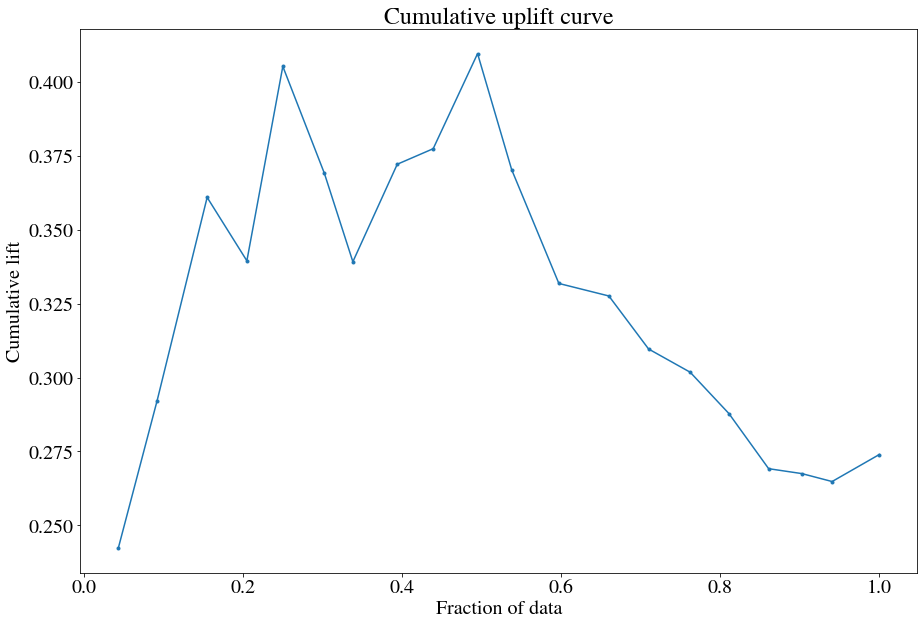

In [13]:
up.plot(plot_type='cuplift')

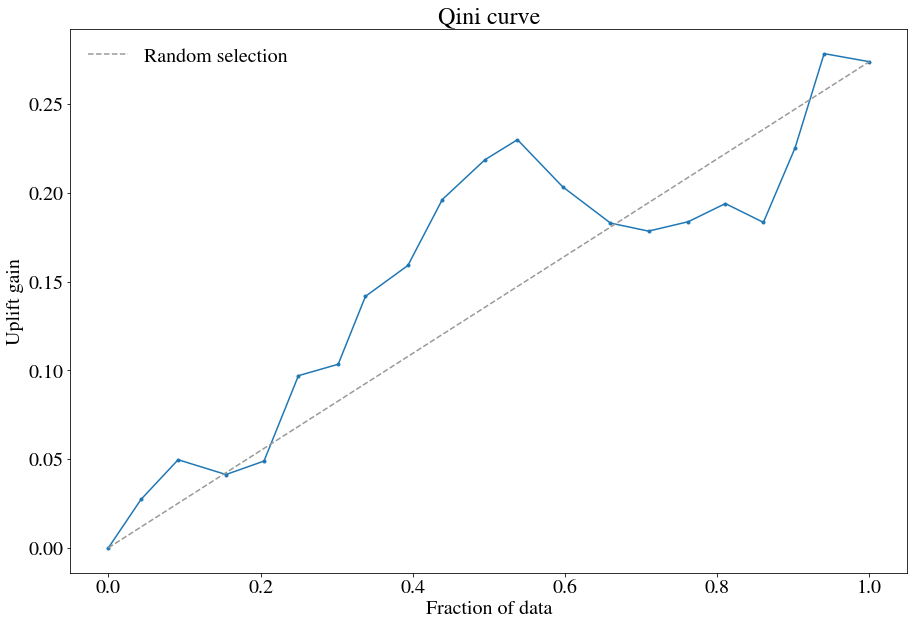

In [14]:
up.plot(plot_type='qini')

<h2>Randomized search

[19:06:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Seed 0 finished.
[19:06:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Seed 1 finished.
[19:06:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Seed 2 finished.
[19:06:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Seed 3 finished.
[19:06:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Seed 4 finished.


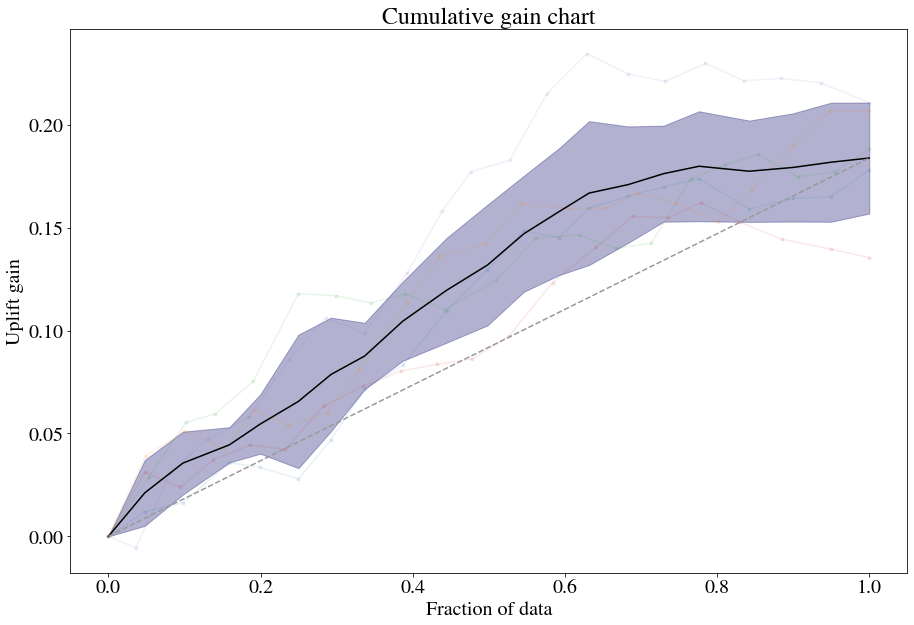

In [15]:
up.shuffle_fit(params=up.rand_search_.best_params_, nthread=30, iterations=5);
up.plot(show_shuffle_fits=True)

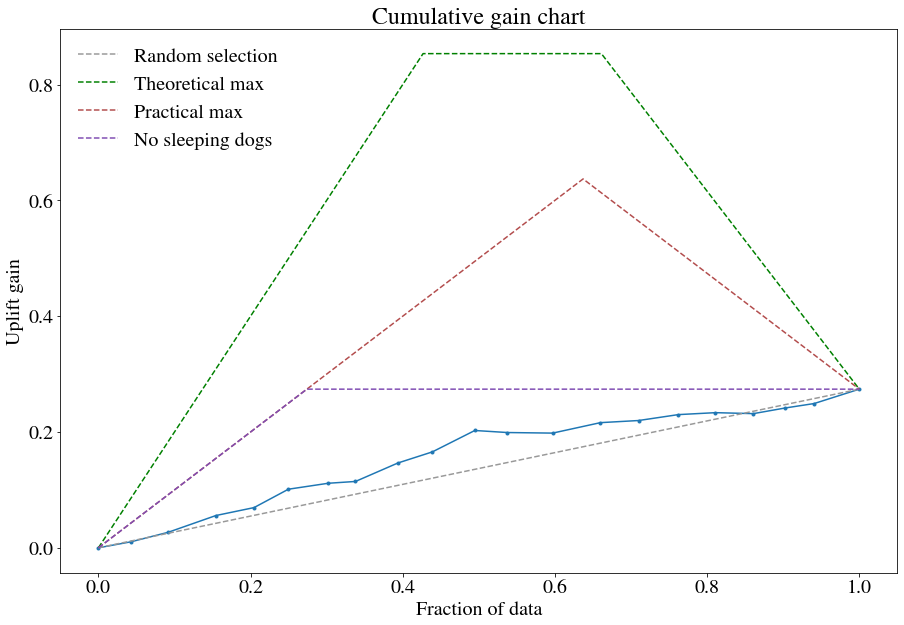

In [16]:
up.plot(show_theoretical_max=True, show_practical_max=True, show_no_dogs=True)

<h1>CUSTOM PREDICTION

Categorizing employees into: CN(0), CR(1), TN(2), and TR(3)
>>Categorizing successfull


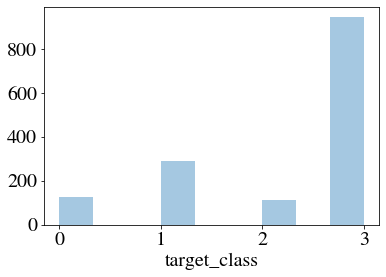

In [17]:
print("Categorizing employees into: CN(0), CR(1), TN(2), and TR(3)")
#to get the CN employees we can simply set the basic value of all data in column target_class equal to 0 
df_model['target_class'] = 0 #CN

#after that we set CR employees with target_class equal to 1 
df_model.loc[(df_model.NotOverTime == 0) & (df_model.Stay > 0),'target_class'] = 1 #CR

#after that we set TN employees with with target_class equal to 2
df_model.loc[(df_model.NotOverTime == 1) & (df_model.Stay == 0),'target_class'] = 2 #TN

#after that we set TR employees with with target_class equal to 3
df_model.loc[(df_model.NotOverTime == 1) & (df_model.Stay > 0),'target_class'] = 3 #TR


#put a copy into df_data
df_data['target_class'] = df_model['target_class']

print(">>Categorizing successfull")
sns.distplot(a=df_model.target_class, kde=False)

In [18]:
#create feature set and labels
X = df_model.drop(['target_class','TransformedOutcome'],axis=1)
y = df_model.target_class
#splitting train and test groups
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#fitting the model and predicting the probabilities using eXtreme Gradient Boosting
xgb_model = xgb.XGBClassifier().fit(X_train, y_train)
#Calculate probabilities for all customers using eXtreme Gradient Boost
overall_predict = xgb_model.predict(df_model.drop(['target_class','TransformedOutcome'],axis=1))
overall_proba=xgb_model.predict_proba(df_model.drop(['target_class','TransformedOutcome'],axis=1))
# df_data_lift = df_model.copy()
df_data['p_target'] = overall_predict
# assign probabilities to 4 different columns
df_data['proba_CN'] = overall_proba[:,0] 
df_data['proba_CR'] = overall_proba[:,1] 
df_data['proba_TN'] = overall_proba[:,2] 
df_data['proba_TR'] = overall_proba[:,3]
#calculate uplift score for all customers
df_data['uplift_score'] = df_data.eval('proba_CN/(proba_CN+proba_CR) + proba_TR/(proba_TN+proba_TR) - proba_TN/(proba_TN+proba_TR) - proba_CR/(proba_CN+proba_CR)')
#assign it back to main dataframe
df_data['uplift_score'] = df_data['uplift_score']

In [19]:
df_model

,Stay,BusinessTravel,Education,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobSatisfaction,NumCompaniesWorked,NotOverTime,PercentSalaryHike,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,TransformedOutcome,target_class
0,0,2,2,2,3,2,4,8,0,11,...,0,0,0,1,0,0,0,1,-0,0
1,0,2,2,1,2,3,3,9,0,13,...,0,0,0,0,0,0,0,1,-0,0
2,1,2,1,2,3,2,3,1,1,25,...,0,0,0,1,0,0,1,0,1.39469,3
3,1,0,4,3,3,2,2,7,1,11,...,0,0,0,1,0,0,1,0,1.39469,3
4,1,1,4,1,3,2,4,1,1,20,...,0,0,0,1,0,0,1,0,1.39469,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,1,2,1,4,3,1,4,3,1,11,...,0,0,0,0,0,0,1,0,1.39469,3
1466,1,2,1,2,3,1,3,0,1,12,...,0,0,0,0,0,0,1,0,1.39469,3
1467,0,1,4,2,3,1,3,0,0,11,...,0,0,0,0,0,1,0,0,-0,0
1468,1,2,2,3,2,1,1,0,1,14,...,0,0,0,0,0,1,0,0,1.39469,3


In [20]:
#create feature set and labels
z = df_model.Stay
#splitting train and test groups
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3, random_state=42)
#fitting the model and predicting the probabilities using eXtreme Gradient Boosting
xgb_model2 = xgb.XGBClassifier().fit(X_train, z_train)
#Calculate probabilities for all customers using eXtreme Gradient Boost
overall_predict2 = xgb_model2.predict(df_model.drop(['target_class','TransformedOutcome'],axis=1))
overall_proba2 = xgb_model2.predict_proba(df_model.drop(['target_class','TransformedOutcome'],axis=1))
# df_data_lift = df_model.copy()
df_data['p_stay'] = overall_predict2
df_data['stay_score'] = overall_proba[:,0] 
df_data['churn_score'] = overall_proba[:,1] 

<h2>rank from uplift score(or not)

In [21]:
# df_data = df_data.sort_values(by ='uplift_score' )
# df_data = df_data.reset_index()
# df_data

In [22]:
j=round(len(df_data)/10)
#1
b1=200
i1=10
c1=1
r1_1=(b1-i1-c1)
r2_1=(-c1)
r3_1=(-i1-c1)
r4_1=(b1-c1)

#2
b2=100
i2=10
c2=1
r1_2=(b2-i2-c2)
r2_2=(-c2)
r3_2=(-i2-c2)
r4_2=(b2-c2)

#3
b3=100
i3=50
c3=1
r1_3=(b3-i3-c3)
r2_3=(-c3)
r3_3=(-i3-c3)
r4_3=(b3-c3)

profit1=[]
profit2=[]
profit3=[]
profit4=[]
profit5=[]
profit6=[]

uplift1=[]
uplift2=[]
uplift3=[]
uplift4=[]
uplift5=[]
uplift6=[]

churn1=[]
churn2=[]
cum1=[]
cum2=[]
for i in range(10):
    n=i*j
    m=(i+1)*j
    CN=sum(df_data.p_target[n:m]==0)
    CR=sum(df_data.p_target[n:m]==1)
    TN=sum(df_data.p_target[n:m]==2)
    TR=sum(df_data.p_target[n:m]==3)
    negative=sum((df_data.p_stay[n:m]==0)&(df_data.Stay[n:m]==0))
    positive=sum((df_data.p_stay[n:m]==1)&(df_data.Stay[n:m]==1))
    falsepositive=sum((df_data.p_stay[n:m]==0)&(df_data.Stay[n:m]==1))
    falsenegative=sum((df_data.p_stay[n:m]==1)&(df_data.Stay[n:m]==0))
    Churn=negative+falsepositive
    NotChurn=positive+falsenegative
    
    #employee churn uplift mp
    mp1=((TR*r1_1)+(TN*r2_1)+((CN+CR)*r3_1))/j
    mp2=((TR*r1_2)+(TN*r2_2)+((CN+CR)*r3_2))/j
    mp3=((TR*r1_3)+(TN*r2_3)+((CN+CR)*r3_3))/j
    
    #employee churn prediction mp
    mp4=((NotChurn*r1_1)+(Churn*r3_1))/j
    mp5=((NotChurn*r1_2)+(Churn*r3_2))/j
    mp6=((NotChurn*r1_3)+(Churn*r3_3))/j
    
    profit1.append(mp1)
    profit2.append(mp2)
    profit3.append(mp3)
    profit4.append(mp4)
    profit5.append(mp5)
    profit6.append(mp6)
    
    #employee churn uplift mpu
    mpu1=((TR*r4_1)-((CN+CR+TN)*i1))/j
    mpu2=((TR*r4_2)-((CN+CR+TN)*i2))/j
    mpu3=((TR*r4_3)-((CN+CR+TN)*i3))/j
    
    #employee churn prediction mpu
    mpu4=((NotChurn*r4_1)-(Churn*i1))/j
    mpu5=((NotChurn*r4_2)-(Churn*i2))/j
    mpu6=((NotChurn*r4_3)-(Churn*i3))/j
    
    uplift1.append(mpu1)
    uplift2.append(mpu2)
    uplift3.append(mpu3)
    uplift4.append(mpu4)
    uplift5.append(mpu5)
    uplift6.append(mpu6)
    
    #employee churn rate
    churn_rate1=(TN)/j    
    churn_rate2=(TN+CN)/j    
    churn1.append(churn_rate1)
    churn2.append(churn_rate2)
    
    #employee cumulative uplift
    cum_uplift_rate1=(CR)/j    
    cum_uplift_rate2=(CR+TR)/j    
    cum1.append(churn_rate1)
    cum2.append(churn_rate2)
    
    print("calculating total employees for Q",i+1,n,m)
    print("CN=",CN)
    print("CR=",CR)
    print("TN=",TN)
    print("TR=",TR)
    print("MP2=",round(mp2),round(mp5))
    print("MPU2=",round(mpu2),round(mpu5))

AttributeError: 'DataFrame' object has no attribute 'Stay'

In [ ]:
cum_profit1=[]
cum_profit2=[]
cum_profit3=[]
cum_profit4=[]
cum_profit5=[]
cum_profit6=[]
for i in range(10):
    cum_profit1.append(sum(profit1[0:i]))
for i in range(10):
    cum_profit2.append(sum(profit2[0:i]))
for i in range(10):
    cum_profit3.append(sum(profit3[0:i]))
for i in range(10):
    cum_profit4.append(sum(profit4[0:i]))
for i in range(10):
    cum_profit5.append(sum(profit5[0:i]))
for i in range(10):
    cum_profit6.append(sum(profit6[0:i]))
    
cum_uplift1=[]
cum_uplift2=[]
cum_uplift3=[]
cum_uplift4=[]
cum_uplift5=[]
cum_uplift6=[]
for i in range(10):
    cum_uplift1.append(sum(uplift1[0:i]))
for i in range(10):
    cum_uplift2.append(sum(uplift2[0:i]))
for i in range(10):
    cum_uplift3.append(sum(uplift3[0:i]))
for i in range(10):
    cum_uplift4.append(sum(uplift4[0:i]))
for i in range(10):
    cum_uplift5.append(sum(uplift5[0:i]))
for i in range(10):
    cum_uplift6.append(sum(uplift6[0:i]))
    
cum_churn1=[]
cum_churn2=[]
for i in range(10):
    cum_churn1.append(sum(churn1[0:i]))
for i in range(10):
    cum_churn2.append(sum(churn2[0:i]))
    
cum_cum1=[]
cum_cum2=[]
for i in range(10):
    cum_cum1.append(sum(cum1[0:i]))
for i in range(10):
    cum_cum2.append(sum(cum2[0:i]))

In [ ]:
quantile=[.1,.2,.3,.4,.5,.6,.7,.8,.9,1]
sns.lineplot(x=quantile,y=cum_profit1, label='CCP1')
sns.lineplot(x=quantile,y=cum_profit4, label='CCU1')

In [ ]:
sns.lineplot(x=quantile,y=cum_profit2, label='CCP2')
sns.lineplot(x=quantile,y=cum_profit5, label='CCU2')

In [ ]:
sns.lineplot(x=quantile,y=cum_profit3, label='CCP3')
sns.lineplot(x=quantile,y=cum_profit6, label='CCU3')

In [ ]:
plt.figure(figsize=(15,10))
sns.lineplot(x=quantile,y=cum_profit1, label='CCP1')
sns.lineplot(x=quantile,y=cum_profit3, label='CCP2')
sns.lineplot(x=quantile,y=cum_profit2, label='CCP3')
sns.lineplot(x=quantile,y=cum_profit4, label='CCU1')
sns.lineplot(x=quantile,y=cum_profit5, label='CCU2')
sns.lineplot(x=quantile,y=cum_profit6, label='CCU3')
plt.title('MP Method')

In [ ]:
sns.lineplot(x=quantile,y=cum_uplift1, label='CCP1')
sns.lineplot(x=quantile,y=cum_uplift4, label='CCU1')

In [ ]:
sns.lineplot(x=quantile,y=cum_uplift2, label='CCP2')
sns.lineplot(x=quantile,y=cum_uplift5, label='CCU2')

In [ ]:
sns.lineplot(x=quantile,y=cum_uplift3, label='CCP3')
sns.lineplot(x=quantile,y=cum_uplift6, label='CCU3')

In [ ]:
plt.figure(figsize=(15,10))
sns.lineplot(x=quantile,y=cum_uplift1, label='CCP1')
sns.lineplot(x=quantile,y=cum_uplift4, label='CCU1')
sns.lineplot(x=quantile,y=cum_uplift2, label='CCP2')
sns.lineplot(x=quantile,y=cum_uplift5, label='CCU2')
sns.lineplot(x=quantile,y=cum_uplift3, label='CCP3')
sns.lineplot(x=quantile,y=cum_uplift6, label='CCU3')
plt.title('MPU Method')

In [ ]:
df_data = df_data.rename(columns={"Attrition": "Stay"})
df_data.Stay.replace(to_replace = dict(Yes = 0, No = 1), inplace = True)


In [ ]:
df_data = df_data.rename(columns={"OverTime": "NotOverTime"})
df_data.NotOverTime.replace(to_replace = dict(Yes = 0, No = 1), inplace = True)

In [ ]:
#Measure QINI
upev = UpliftEval(df_data.NotOverTime, df_data.Stay,df_data.stay_score)
upev.plot(plot_type='cuplift')
plt.title('Churn Prediction - Cumulative Uplift')
up.plot(plot_type='cuplift')
plt.title('Uplift Prediction - Cumulative Uplift')

In [ ]:
#Measure QINI
upev = UpliftEval(df_data.NotOverTime, df_data.Stay,df_data.stay_score)
upev.plot(plot_type='qini')
plt.title('Churn Prediction - QINI Curve')
up.plot(plot_type='qini')
plt.title('Churn Uplift - QINI Curve')

In [ ]:
df_data.NotOverTime

In [ ]:
plt.figure(figsize=(15,10))
sns.lineplot(x=quantile,y=churn1, label='churn uplift')
sns.lineplot(x=quantile,y=churn2, label='churn prediction')
plt.title('Churn Rate')

In [ ]:
plt.figure(figsize=(15,10))
sns.lineplot(x=quantile,y=cum_cum1, label='churn uplift')
sns.lineplot(x=quantile,y=cum_cum2, label='churn prediction')
plt.title('cumulative uplift')